## Cluster Profiling

Statistical analysis and visualization of functional profiles for genes and gene clusters.

> In recently years, high-throughput experimental techniques such as microarray, RNA-Seq and mass spectrometry can detect cellular molecules at systems-level. These kinds of analyses generate huge quantitaties of data, which need to be given a biological interpretation. A commonly used approach is via clustering in the gene dimension for grouping different genes based on their [similarities](https://pubmed.ncbi.nlm.nih.gov/20179076/).

> To search for shared functions among genes, a common way is to incorporate the biological knowledge, such as Gene Ontology (GO) and Kyoto Encyclopedia of Genes and Genomes (KEGG), for identifying predominant biological themes of a collection of genes.

In [1]:
origin <- getwd()

# Load my own function from the library directory
libdir <- "../utils/"
setwd(libdir)
source("ontology_utils.R")
setwd(origin)

# Change directory to workspace (where to store the data).
basedir <- "../"
setwd(basedir)



Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

DOSE v3.12.0  For help: https://guangchuangyu.github.io/software/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required package: ggplot2

Loading required package: ggdendro

Loading required package: gridExtra

Loading required package: RColorBrewer

Bioconductor version 3.10 (BiocManager 1.30.10), ?BiocManager::install for help

Bio

### Supported ontologies/pathways

- Disease Ontology (via [`DOSE`](https://bioconductor.org/packages/release/bioc/html/DOSE.html))
- Gene Ontology (supports many species with GO annotation query online via [AnnotationHub](https://bioconductor.org/packages/AnnotationHub/))
- KEGG Pathway and Module with latest online data (supports more than 4000 species listed in [KEGG Organisms](http://www.genome.jp/kegg/catalog/org_list.html))
- Protein-protein interaction

### mRNA(DEGs)

<div style="border: solid 1.0px #000000; padding: 0 1em;">
  <h4>Index</h4>
  <ul>
    <li><a href="#[DEGs]-Gene-Ontology">Gene Ontology</a>
    <li><a href="#[DEGs]-KEGG-pathways">KEGG pathways</a>
    <li><a href="#[DEGs]-Disease-Ontology">Disease Ontology</a>
    <li><a href="#[DEGs]-Protein-protein-interaction">Protein protein interaction</a>
  </ul>
</div>

In [2]:
mRNA_data_dir <- "data/GEOquery/DEGs/"
fig2_save_dir <- "image/Figure.2.GO.KEGG.DO/"
DEGs   <- scan(paste(mRNA_data_dir, "1.Microarray.thresholding.310data.txt",       sep=""), what="character")
ALLGs  <- scan(paste(mRNA_data_dir, "0.Download.and.Pre-processing.33342data.txt", sep=""), what="character")

[`clusterProfiler`](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) provides bitr and bitr_kegg for converting ID types. User should provides an annotation package, both `fromType` and `toType` can accept any types that supported. (Supported types are shown using `keytypes` command.)

```R
library(org.Hs.eg.db)
keytypes(org.Hs.eg.db)
```

```R
# `bitr`: Biological Id TranslatoR
# `bitr_kegg`: Converting biological IDs using KEGG API
eg <- bitr(DEGs, fromType="SYMBOL", toType=c("ENSEMBL"), OrgDb ="org.Hs.eg.db")
head(eg, 3)
```

#### [DEGs] Gene Ontology

```R
# `groupGO` is designed for gene classification based on GO distribution at a specific level.
ggo <- groupGO(gene=DEGs, OrgDb="org.Hs.eg.db", keyType="SYMBOL", ont="CC", level=2, readable=FALSE)
head(ggo, 3)
barplot(ggo)
```

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, 

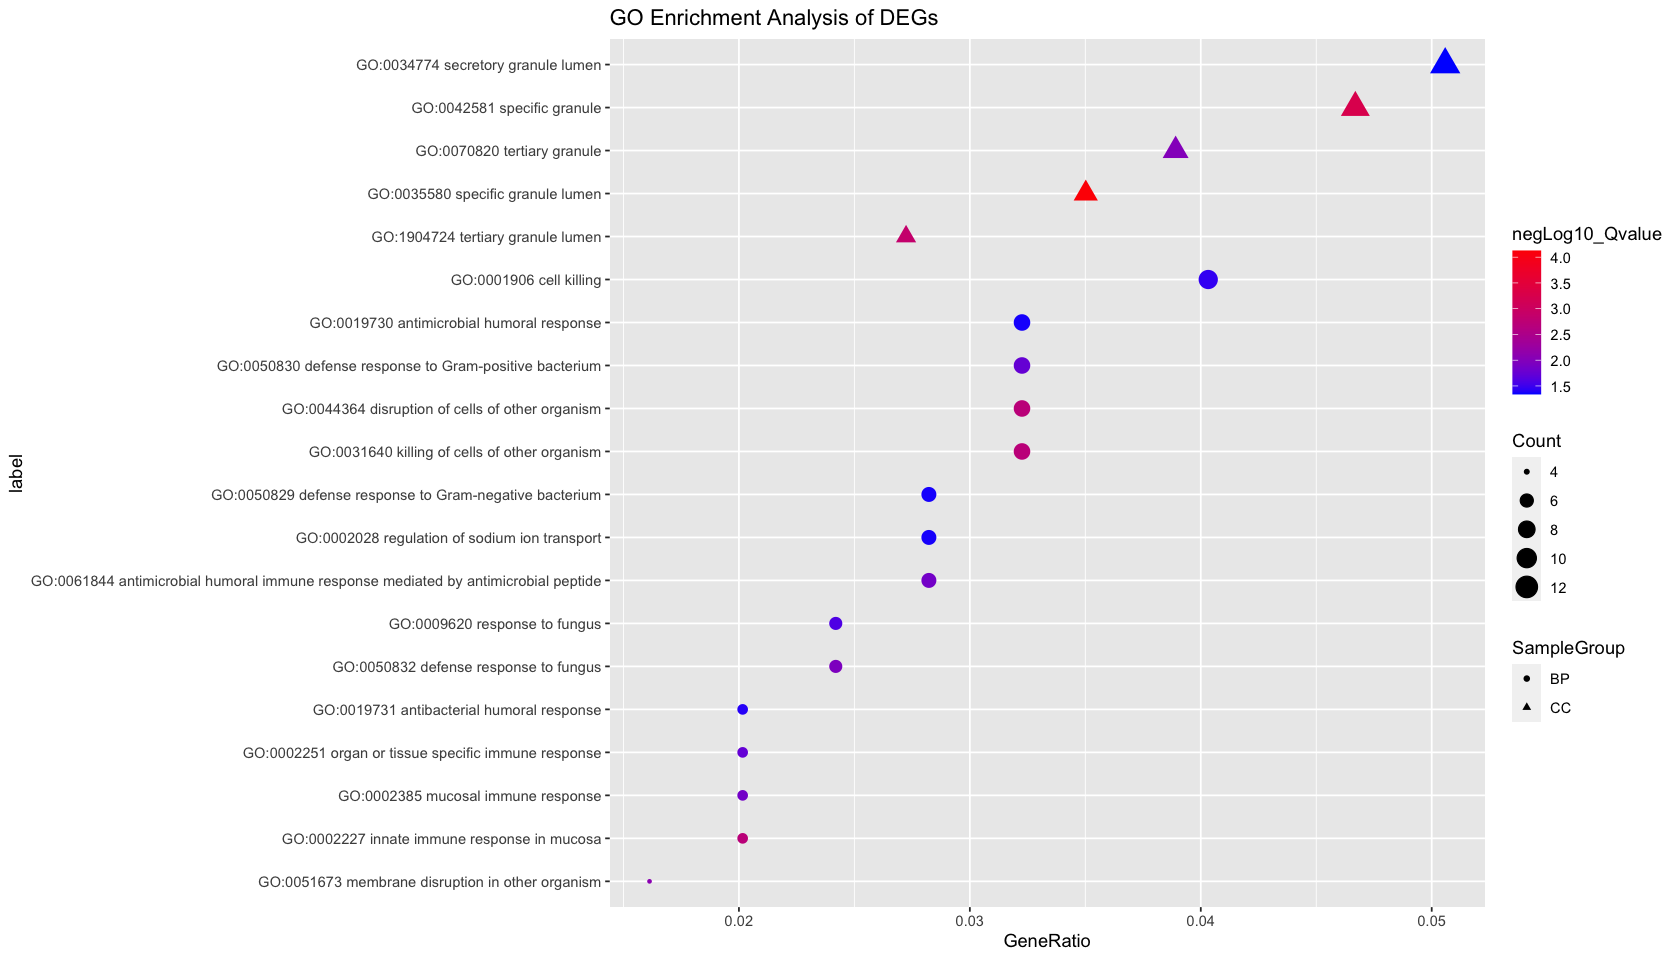

In [3]:
fig2.A.path <- paste(fig2_save_dir, "fig.2.a.GO-for-DEGs.png", sep="")
fig2.A <- enrichGOdotplot(gene=DEGs, OrgDb="org.Hs.eg.db", keyType="SYMBOL", pvalueCutoff=0.05, pAdjustMethod="BH",
                          universe=ALLGs, qvalueCutoff=0.2, minGSSize=10, maxGSSize=500, readable=FALSE,
                          title="GO Enrichment Analysis of DEGs")
myggsave(fig2.A.path)
fig2.A

#### [DEGs] KEGG pathways

#### [DEGs] Disease Ontology

#### [DEGs] Protein-protein interaction

### miRNA(DEMis)

<div style="border: solid 1.0px #000000; padding: 0 1em;">
  <h4>Index</h4>
  <ul>
    <li><a href="#[DEMis]-KEGG-pathways">KEGG pathways</a>
    <li><a href="#[DEMis]-Disease-Ontology">Disease Ontology</a>
  </ul>
</div>

In [4]:
miRNA_data_dir <- "data/GEOquery/DEMis/"
fig2_save_dir  <- "image/Figure.2.GO.KEGG.DO/"
DEGs   <- scan(paste(miRNA_data_dir, "1.Microarray.thresholding.123data.txt",     sep=""), what="character")
ALLGs  <- scan(paste(miRNA_data_dir, "0.Download.and.Pre-processing.862data.txt", sep=""), what="character")

#### [DEMis] KEGG pathways

#### [DEMis] Disease Ontology

### Reference

- [GOSemSim: An R Package for Measuring Semantic Similarity Among GO Terms and Gene Products](https://pubmed.ncbi.nlm.nih.gov/20179076/)
- [Statistical analysis and visualization of functional profiles for genes and gene clusters](https://bioc.ism.ac.jp/packages/3.6/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html) 
- package:
   - [`GOplot`](https://cran.r-project.org/web/packages/GOplot/index.html)
   - [`DOSE`](https://bioconductor.org/packages/release/bioc/html/DOSE.html)
   - [`clusterProfiler`](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html)